# Routing algorithm tests for vehicle agents

In [11]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, deque
import heapq
import random
import math
import os
random.seed(42) 


# Create the necessary classes

In [12]:
class VehicleRoutingSystem:
    def __init__(self):
        self.nodes = {}
        self.connections = defaultdict(list)
        self.graph = nx.Graph()
        self.vehicles = {}
        self.edge_weights = {}  # Store carbon emissions and cost
        
    def load_map(self, file_path):
        """Load map data from map.txt file"""
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    line = line.strip()
                    if line:
                        # Parse the format: {{"Node1", {250,50}},["Node2","Node3","Node4","Node5","Node6"]}.
                        print(f"Parsing line: {line}")  # Debug print
                        
                        # Remove outer braces and period
                        line = line.strip('{}.}')
                        
                        # Find the node name (between first two quotes)
                        node_start = line.find('"') + 1
                        node_end = line.find('"', node_start)
                        node_name = line[node_start:node_end]
                        
                        # Find coordinates (between { and })
                        coord_start = line.find('{', node_end) + 1
                        coord_end = line.find('}', coord_start)
                        coords_str = line[coord_start:coord_end]
                        
                        # Parse coordinates
                        coords = coords_str.split(',')
                        x = int(coords[0].strip())
                        y = int(coords[1].strip())
                        
                        self.nodes[node_name] = (x, y)
                        self.graph.add_node(node_name, pos=(x, y))
                        
                        # Find connections (between [ and ])
                        bracket_start = line.find('[')
                        if bracket_start != -1:
                            bracket_end = line.find(']', bracket_start)
                            if bracket_end != -1:
                                connections_str = line[bracket_start+1:bracket_end]
                                if connections_str.strip():
                                    # Split by comma and clean up quotes
                                    connections = [conn.strip().strip('"') for conn in connections_str.split('","')]
                                    # Handle first and last items that might have extra quotes
                                    connections = [conn.strip('"') for conn in connections]
                                    for conn in connections:
                                        if conn:  # Make sure connection is not empty
                                            self.connections[node_name].append(conn)
                        
                        print(f"  Added node: {node_name} at {(x, y)} with connections: {self.connections[node_name]}")
                                        
            print(f"Loaded {len(self.nodes)} nodes from map file")
            self._build_graph()
            
        except FileNotFoundError:
            print(f"Map file not found at {file_path}")
            print("Creating sample data for demonstration...")
            self._create_sample_map()
        except Exception as e:
            print(f"Error parsing map file: {e}")
            print("Creating sample data for demonstration...")
            self._create_sample_map()
            
    def _create_sample_map(self):
        """Create sample map data if file is not found"""
        sample_data = [
            ("Node1", (250, 50), ["Node2", "Node3", "Node4", "Node5", "Node6"]),
            ("Node2", (450, 50), []),
            ("Node3", (50, 50), []),
            ("Node4", (250, 250), []),
            ("Node5", (150, 125), []),
            ("Node6", (350, 125), [])
        ]
        
        for node_name, coords, connections in sample_data:
            self.nodes[node_name] = coords
            self.graph.add_node(node_name, pos=coords)
            for conn in connections:
                self.connections[node_name].append(conn)
                
        self._build_graph()
        
    def _build_graph(self):
        """Build the graph with edges and assign random weights"""
        for node, connected_nodes in self.connections.items():
            for connected_node in connected_nodes:
                if connected_node in self.nodes:
                    # Calculate distance
                    x1, y1 = self.nodes[node]
                    x2, y2 = self.nodes[connected_node]
                    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                    
                    # Assign random weights (carbon emissions and cost)
                    carbon_emission = random.uniform(0.1, 2.0) * distance  # kg CO2 per unit distance
                    cost = random.uniform(0.1, 5.0) * distance  # cost per unit distance
                    
                    # Add edge to graph
                    self.graph.add_edge(node, connected_node, 
                                      distance=distance, 
                                      carbon=carbon_emission, 
                                      cost=cost)
                    
                    # Store weights for easy access
                    edge_key = tuple(sorted([node, connected_node]))
                    self.edge_weights[edge_key] = {
                        'distance': distance,
                        'carbon': carbon_emission,
                        'cost': cost
                    }
    
    def load_vehicles(self, file_path):
        """Load vehicle data from vehicles.txt file"""
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    line = line.strip()
                    if line:
                        # Parse format: {1, 30, "Node1"}.
                        print(f"Parsing vehicle line: {line}")  # Debug print
                        
                        # Remove outer braces and period
                        line = line.strip('{}.')
                        
                        # Split by comma
                        parts = [p.strip() for p in line.split(',')]
                        
                        vehicle_id = int(parts[0])
                        speed = int(parts[1])
                        start_node = parts[2].strip('"')  # Remove quotes
                        
                        self.vehicles[vehicle_id] = {
                            'speed': speed,
                            'start_node': start_node
                        }
                        
                        print(f"  Added vehicle: {vehicle_id}, speed: {speed}, start: {start_node}")
                        
            print(f"Loaded {len(self.vehicles)} vehicles from file")
            
        except FileNotFoundError:
            print(f"Vehicle file not found at {file_path}")
            print("Creating sample vehicle data for demonstration...")
            self._create_sample_vehicles()
        except Exception as e:
            print(f"Error parsing vehicles file: {e}")
            print("Creating sample vehicle data for demonstration...")
            self._create_sample_vehicles()
    
    def _create_sample_vehicles(self):
        """Create sample vehicle data if file is not found"""
        sample_vehicles = [
            (1, 30, "Node1"),
            (2, 45, "Node1"),
            (3, 60, "Node1"),
            (4, 75, "Node1"),
            (5, 90, "Node1")
        ]
        
        for vehicle_id, speed, start_node in sample_vehicles:
            self.vehicles[vehicle_id] = {
                'speed': speed,
                'start_node': start_node
            }
    
    def visualize_network(self, figsize=(12, 8)):
        """Visualize the network graph with (0,0) at top-left, (400,400) at bottom-right"""
        plt.figure(figsize=figsize)
        
        # Get positions for nodes - no transformation needed since we want 
        # (0,0) at top-left which is matplotlib's default for inverted y-axis
        pos = nx.get_node_attributes(self.graph, 'pos')
        
        # Draw the network
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue', 
                             node_size=800, alpha=0.7)
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_weight='bold')
        nx.draw_networkx_edges(self.graph, pos, alpha=0.5, width=2)
        
        # Add edge labels with weights
        edge_labels = {}
        for edge in self.graph.edges():
            edge_data = self.graph.edges[edge]
            edge_labels[edge] = f"D:{edge_data['distance']:.1f}\nC:{edge_data['carbon']:.1f}\n$:{edge_data['cost']:.1f}"
        
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=8)
        
        plt.title("Vehicle Routing Network\n(D=Distance, C=Carbon Emission, $=Cost)")
        plt.axis('equal')
        plt.grid(True, alpha=0.3)
        
        # Set axis limits and invert y-axis for computer graphics coordinate system
        # where (0,0) is top-left and y increases downward
        plt.xlim(100, 400)
        plt.ylim(50, 400)
        plt.gca().invert_yaxis()
        
        # Add axis labels
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis (inverted)')
        
        plt.tight_layout()
        plt.show()
    
    def dijkstra_shortest_path(self, start_node, end_node, weight_type='distance'):
        """Find shortest path using Dijkstra's algorithm"""
        if start_node not in self.graph.nodes() or end_node not in self.graph.nodes():
            return None, float('inf')
        
        # Initialize distances and previous nodes
        distances = {node: float('inf') for node in self.graph.nodes()}
        previous = {node: None for node in self.graph.nodes()}
        distances[start_node] = 0
        
        # Priority queue: (distance, node)
        pq = [(0, start_node)]
        visited = set()
        
        while pq:
            current_distance, current_node = heapq.heappop(pq)
            
            if current_node in visited:
                continue
                
            visited.add(current_node)
            
            if current_node == end_node:
                break
            
            # Check neighbors
            for neighbor in self.graph.neighbors(current_node):
                if neighbor not in visited:
                    edge_data = self.graph.edges[current_node, neighbor]
                    weight = edge_data[weight_type]
                    distance = current_distance + weight
                    
                    if distance < distances[neighbor]:
                        distances[neighbor] = distance
                        previous[neighbor] = current_node
                        heapq.heappush(pq, (distance, neighbor))
        
        # Reconstruct path
        if distances[end_node] == float('inf'):
            return None, float('inf')
        
        path = []
        current = end_node
        while current is not None:
            path.append(current)
            current = previous[current]
        path.reverse()
        
        return path, distances[end_node]
    
    def find_optimal_paths(self, start_node, end_node):
        """Find paths optimized for different criteria"""
        results = {}
        
        # Find shortest distance path
        path_distance, total_distance = self.dijkstra_shortest_path(start_node, end_node, 'distance')
        results['shortest_distance'] = {
            'path': path_distance,
            'total_distance': total_distance,
            'total_carbon': self._calculate_path_weight(path_distance, 'carbon'),
            'total_cost': self._calculate_path_weight(path_distance, 'cost')
        }
        
        # Find lowest carbon emission path
        path_carbon, total_carbon = self.dijkstra_shortest_path(start_node, end_node, 'carbon')
        results['lowest_carbon'] = {
            'path': path_carbon,
            'total_distance': self._calculate_path_weight(path_carbon, 'distance'),
            'total_carbon': total_carbon,
            'total_cost': self._calculate_path_weight(path_carbon, 'cost')
        }
        
        # Find lowest cost path
        path_cost, total_cost = self.dijkstra_shortest_path(start_node, end_node, 'cost')
        results['lowest_cost'] = {
            'path': path_cost,
            'total_distance': self._calculate_path_weight(path_cost, 'distance'),
            'total_carbon': self._calculate_path_weight(path_cost, 'carbon'),
            'total_cost': total_cost
        }
        
        return results
    
    def _calculate_path_weight(self, path, weight_type):
        """Calculate total weight for a given path"""
        if not path or len(path) < 2:
            return 0
        
        total_weight = 0
        for i in range(len(path) - 1):
            edge_data = self.graph.edges[path[i], path[i+1]]
            total_weight += edge_data[weight_type]
        
        return total_weight
    
    def calculate_travel_times(self, path, vehicle_id):
        """Calculate travel time for a path using specific vehicle"""
        if not path or len(path) < 2:
            return 0
        
        if vehicle_id not in self.vehicles:
            return None
        
        vehicle_speed = self.vehicles[vehicle_id]['speed']
        total_distance = self._calculate_path_weight(path, 'distance')
        
        # Time = Distance / Speed
        travel_time = total_distance / vehicle_speed
        
        return travel_time
    
    def analyze_route(self, start_node, end_node):
        """Complete route analysis with all vehicles"""
        print(f"\n{'='*60}")
        print(f"ROUTE ANALYSIS: {start_node} → {end_node}")
        print(f"{'='*60}")
        
        # Find optimal paths
        optimal_paths = self.find_optimal_paths(start_node, end_node)
        
        for criterion, data in optimal_paths.items():
            print(f"\n{criterion.upper().replace('_', ' ')}:")
            print(f"  Path: {' → '.join(data['path'])}")
            print(f"  Distance: {data['total_distance']:.2f} units")
            print(f"  Carbon: {data['total_carbon']:.2f} kg CO2")
            print(f"  Cost: ${data['total_cost']:.2f}")
            
            # Calculate times for all vehicles
            print(f"  Travel times by vehicle:")
            for vehicle_id, vehicle_data in self.vehicles.items():
                travel_time = self.calculate_travel_times(data['path'], vehicle_id)
                if travel_time is not None:
                    print(f"    Vehicle {vehicle_id} (speed {vehicle_data['speed']}): {travel_time:.2f} time units")
    
    def print_network_summary(self):
        """Print summary of the network"""
        print("NETWORK SUMMARY")
        print("="*50)
        print(f"Nodes: {len(self.nodes)}")
        print(f"Edges: {len(self.graph.edges())}")
        print(f"Vehicles: {len(self.vehicles)}")
        
        print("\nNodes and Coordinates:")
        for node, coords in self.nodes.items():
            print(f"  {node}: {coords}")
        
        print("\nVehicles:")
        for vehicle_id, data in self.vehicles.items():
            print(f"  Vehicle {vehicle_id}: Speed {data['speed']}, Start: {data['start_node']}")


# Test code

In [13]:
vrs = VehicleRoutingSystem()

# File paths
base_path = r"C:\Users\hhy26\OneDrive - University of Cambridge\Desktop\01_PhD\04_First_Year_Report\00_vehicle_simulator_0.1.2\vehicle_simulator"
map_file = os.path.join(base_path, "map.txt")
vehicles_file = os.path.join(base_path, "vehicles.txt")

# Load data
print("Loading map data...")
vrs.load_map(map_file)

Loading map data...
Parsing line: {{"Node1", {250,250}},["Node2","Node3","Node4","Node5","Node6","Node7"]}.
  Added node: Node1 at (250, 250) with connections: ['Node2', 'Node3', 'Node4', 'Node5', 'Node6', 'Node7']
Parsing line: {{"Node2", {250,150}},["Node8","Node9","Node5","Node4"]}.
  Added node: Node2 at (250, 150) with connections: ['Node8', 'Node9', 'Node5', 'Node4']
Parsing line: {{"Node3", {250,350}},["Node6","Node7"]}.
  Added node: Node3 at (250, 350) with connections: ['Node6', 'Node7']
Parsing line: {{"Node4", {350,200}},["Node6"]}.
  Added node: Node4 at (350, 200) with connections: ['Node6']
Parsing line: {{"Node5", {150,200}},["Node7"]}.
  Added node: Node5 at (150, 200) with connections: ['Node7']
Parsing line: {{"Node6", {400,300}},[]}.
  Added node: Node6 at (400, 300) with connections: []
Parsing line: {{"Node7", {100,300}},[]}.
  Added node: Node7 at (100, 300) with connections: []
Parsing line: {{"Node8", {200,100}},["Node9"]}.
  Added node: Node8 at (200, 100) wit

In [14]:
print("\nLoading vehicle data...")
vrs.load_vehicles(vehicles_file)

# Print network summary
print("\n")
vrs.print_network_summary()


Loading vehicle data...
Parsing vehicle line: {1, 35, "Node1"}.
  Added vehicle: 1, speed: 35, start: Node1
Parsing vehicle line: {2, 45, "Node2"}.
  Added vehicle: 2, speed: 45, start: Node2
Parsing vehicle line: {3, 50, "Node3"}.
  Added vehicle: 3, speed: 50, start: Node3
Loaded 3 vehicles from file


NETWORK SUMMARY
Nodes: 9
Edges: 15
Vehicles: 3

Nodes and Coordinates:
  Node1: (250, 250)
  Node2: (250, 150)
  Node3: (250, 350)
  Node4: (350, 200)
  Node5: (150, 200)
  Node6: (400, 300)
  Node7: (100, 300)
  Node8: (200, 100)
  Node9: (300, 100)

Vehicles:
  Vehicle 1: Speed 35, Start: Node1
  Vehicle 2: Speed 45, Start: Node2
  Vehicle 3: Speed 50, Start: Node3


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



Generating network visualization...


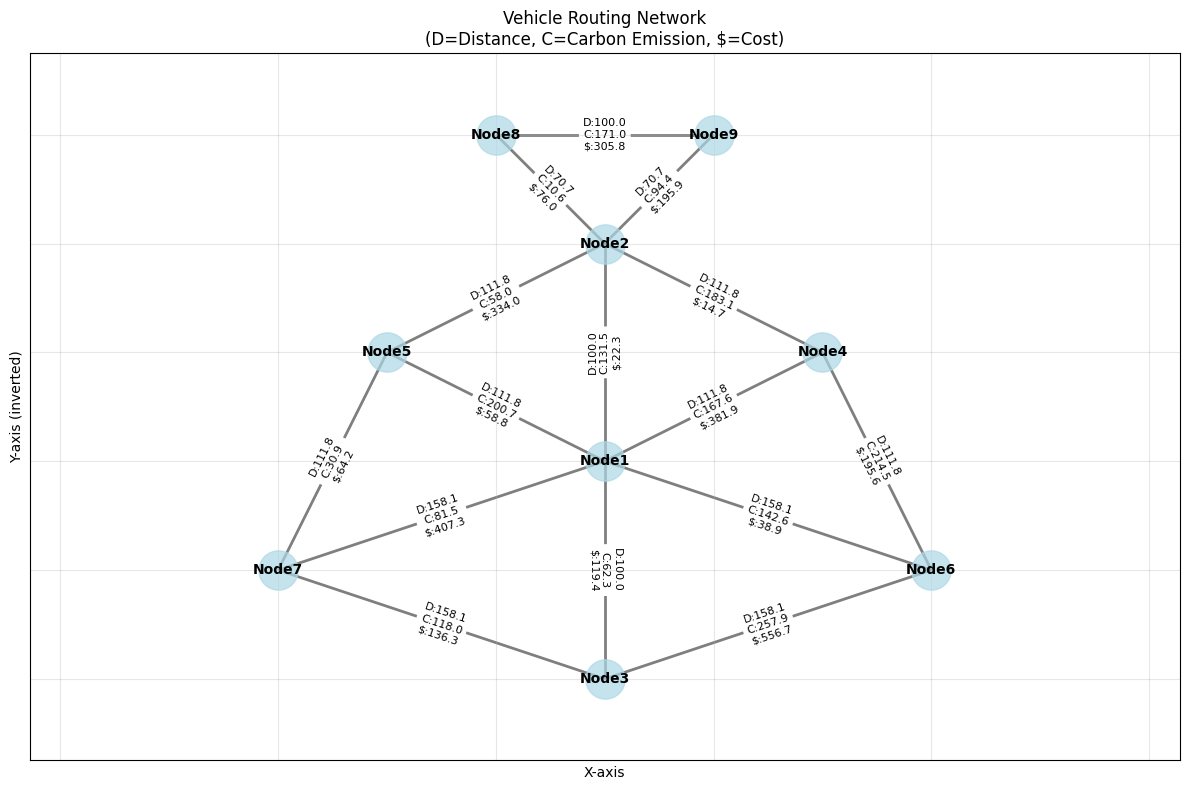

In [15]:
# Visualize the network
print("\nGenerating network visualization...")
vrs.visualize_network()

In [20]:
    # Analyze routes
    print("\nPerforming route analysis...")
    
    # Example route analysis
    start_node = "Node7"
    end_node = "Node4"
    vrs.analyze_route(start_node, end_node)


Performing route analysis...

ROUTE ANALYSIS: Node7 → Node4

SHORTEST DISTANCE:
  Path: Node7 → Node1 → Node4
  Distance: 269.92 units
  Carbon: 249.12 kg CO2
  Cost: $789.24
  Travel times by vehicle:
    Vehicle 1 (speed 35): 7.71 time units
    Vehicle 2 (speed 45): 6.00 time units
    Vehicle 3 (speed 50): 5.40 time units

LOWEST CARBON:
  Path: Node7 → Node1 → Node4
  Distance: 269.92 units
  Carbon: 249.12 kg CO2
  Cost: $789.24
  Travel times by vehicle:
    Vehicle 1 (speed 35): 7.71 time units
    Vehicle 2 (speed 45): 6.00 time units
    Vehicle 3 (speed 50): 5.40 time units

LOWEST COST:
  Path: Node7 → Node5 → Node1 → Node2 → Node4
  Distance: 435.41 units
  Carbon: 546.20 kg CO2
  Cost: $159.97
  Travel times by vehicle:
    Vehicle 1 (speed 35): 12.44 time units
    Vehicle 2 (speed 45): 9.68 time units
    Vehicle 3 (speed 50): 8.71 time units


In [17]:
start_node = "Node3"
end_node = "Node9"
vrs.analyze_route(start_node, end_node)


ROUTE ANALYSIS: Node3 → Node9

SHORTEST DISTANCE:
  Path: Node3 → Node1 → Node2 → Node9
  Distance: 270.71 units
  Carbon: 288.13 kg CO2
  Cost: $337.51
  Travel times by vehicle:
    Vehicle 1 (speed 35): 7.73 time units
    Vehicle 2 (speed 45): 6.02 time units
    Vehicle 3 (speed 50): 5.41 time units

LOWEST CARBON:
  Path: Node3 → Node1 → Node2 → Node9
  Distance: 270.71 units
  Carbon: 288.13 kg CO2
  Cost: $337.51
  Travel times by vehicle:
    Vehicle 1 (speed 35): 7.73 time units
    Vehicle 2 (speed 45): 6.02 time units
    Vehicle 3 (speed 50): 5.41 time units

LOWEST COST:
  Path: Node3 → Node1 → Node2 → Node9
  Distance: 270.71 units
  Carbon: 288.13 kg CO2
  Cost: $337.51
  Travel times by vehicle:
    Vehicle 1 (speed 35): 7.73 time units
    Vehicle 2 (speed 45): 6.02 time units
    Vehicle 3 (speed 50): 5.41 time units
